# Gradient descent training of a rate-based reservoir model
This notebook demonstrates using `NetworksPython` and a `jax`-accelerated rate-based reservoir layer to perform gradient descent training of all network parameters

In [22]:
# - Imports and boilerplate
from NetworksPython import TimeSeries, TSContinuous
from NetworksPython.layers import RecRateEulerJax, H_ReLU, H_tanh
from NetworksPython.utilities import add_train_output
from tqdm import tnrange
from tqdm.autonotebook import tqdm

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib notebook

We will use a pulse-to-chirp task as a demonstration. The reservoir receives a short pulse, and must respond by generating a chirp signal. This task is difficult, as no input is present for most of the time, and so considerable reservoir memory is required.

You can adjust the parameters of the input by changing the number of repeats `num_repeats`, the duration of the input pulse `pulse_duration`, and the maximum frequency reached by the chirp `chirp_freq_factor`. Shorter pulses and higher chirp frequencies make the problem more difficult. More repeats make learning more difficult, by forcing gradients to be accumulated over more time steps.

You can also adjust the time step `dt`, which makes learning slower (more time points evaluated per trial), but which permits shorter time constants to be used in the network. For numerical stability, time constants must be at least `10*dt`.

<IPython.core.display.Javascript object>


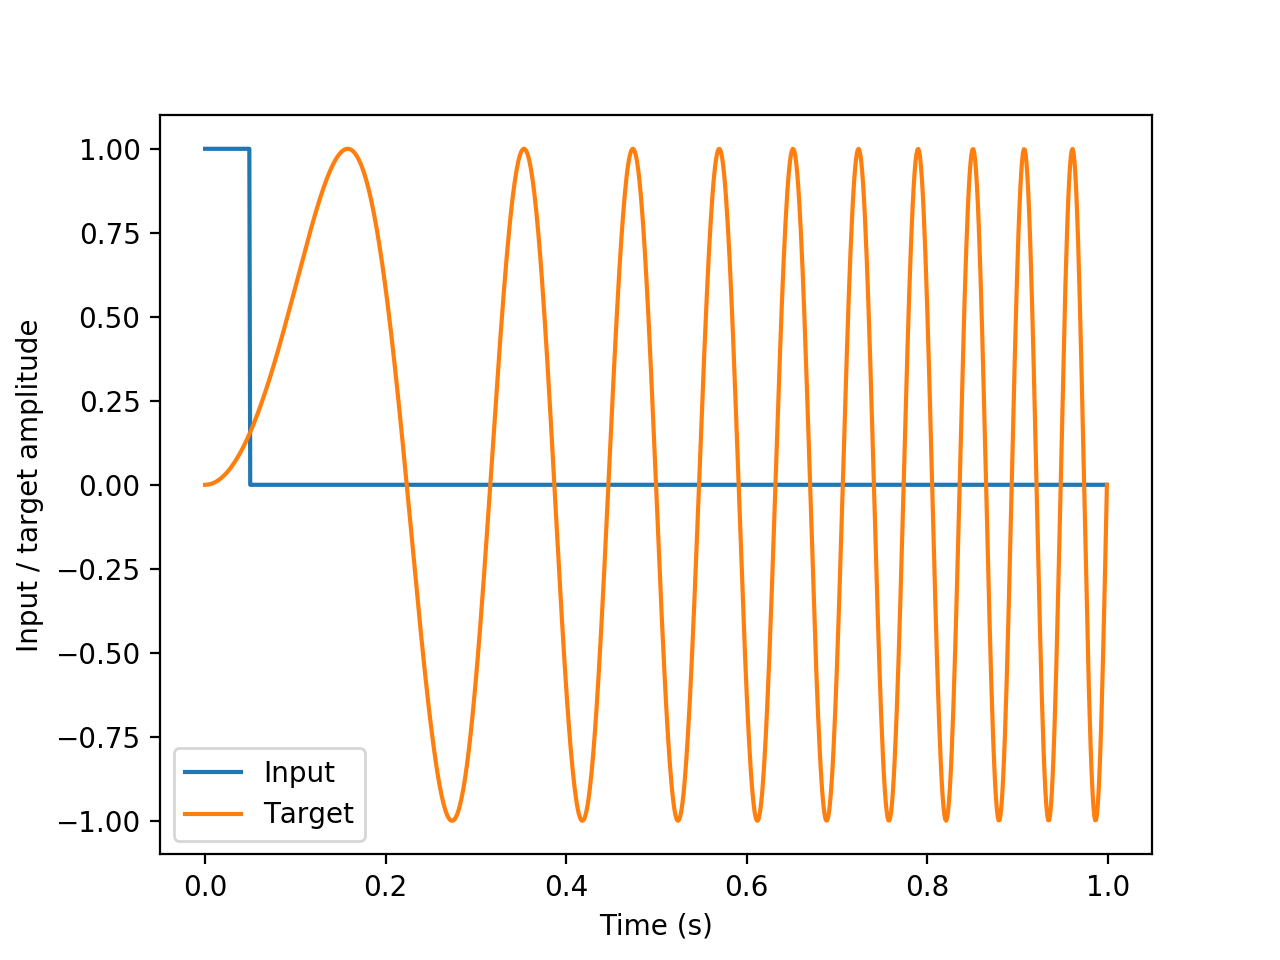

In [59]:
# - Define input and target signals
num_repeats = 1
pulse_duration = 50e-3
chirp_freq_factor = 10
dt = 1e-3

time_end = int(np.round(1 / dt))
timebase = np.linspace(0, time_end * dt, time_end)

trigger = np.atleast_2d(timebase < pulse_duration).T

chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T

timebase = np.linspace(0, time_end * num_repeats, time_end * num_repeats + 1)
timebase = timebase[:-1] * dt
input_t = np.tile(trigger, (num_repeats, 1))
target_t = np.tile(chirp, (num_repeats, 1))

# - Generate time series objects
ts_input = TSContinuous(timebase, input_t, periodic=True)
ts_target = TSContinuous(timebase, target_t, periodic=True)

# - Plot the input and target signals
plt.figure()
plt.plot(
     timebase,
     input_t,
     timebase,
     target_t,
     # timebase, target_t + np.diff(np.vstack((target_t, target_t[0])), axis=0) / dt * tau,
 )
plt.xlabel('Time (s)')
plt.ylabel('Input / target amplitude')
plt.legend(("Input", "Target"));

We will define a ReLU reservoir, with a single input and a single output channel, and with a chosen number of units in the recurrent layer `nResSize`. Larger reservoirs take longer to train, but perform the task to higher accuracy.

Weight initialisation doesn't seem to matter too much; gradient descent does a good job even when weights are initially zero. Here we use a standard initialisation with unit spectral radius for the recurrent weights.

You can change the activation function to one of `H_tanh` or `H_ReLU`. You can define your own, but must use `jax.numpy` to do so.

In [53]:
# - Define the reservoir parameters
nResSize = 100
tau = 20e-3
bias = 0
activation_func = H_ReLU
noise_std = 0.1

# - Build a layer
nInSize = 1
nOutSize = 1
w_in = 2*npr.rand(nInSize, nResSize)-1
w_rec = npr.randn(nResSize, nResSize) / np.sqrt(nResSize)
w_out = 2*npr.rand(nResSize, nOutSize)-1

lyrRes = RecRateEulerJax(w_in, w_rec, w_out, tau, bias,
                         dt=dt, noise_std=noise_std,
                         activation_func = activation_func)

# - Get initial output
ts_output0 = lyrRes.evolve(ts_input)

In [60]:
# - Initialise training
lyrRes = add_train_output(lyrRes)

# - Force initialisation of training
lyrRes.train_adam(ts_input, ts_target, is_first=True);

Here we use the training method `.train_adam()` to perform stochastic descent using the Adam optimiser. You can re-run the cell below as many times as you like if you want to extend the training time.

The loss function is a combination of mean-squared-error between the reservoir output and the target signal; a factor that harshly penalises time constants shorter than the minimum time constant; and factor related to the 2-norm of the recurrent weight matrix `np.mean(w_recurrent ** 2)`. This helps to ensure that the network remains stable.

<IPython.core.display.Javascript object>


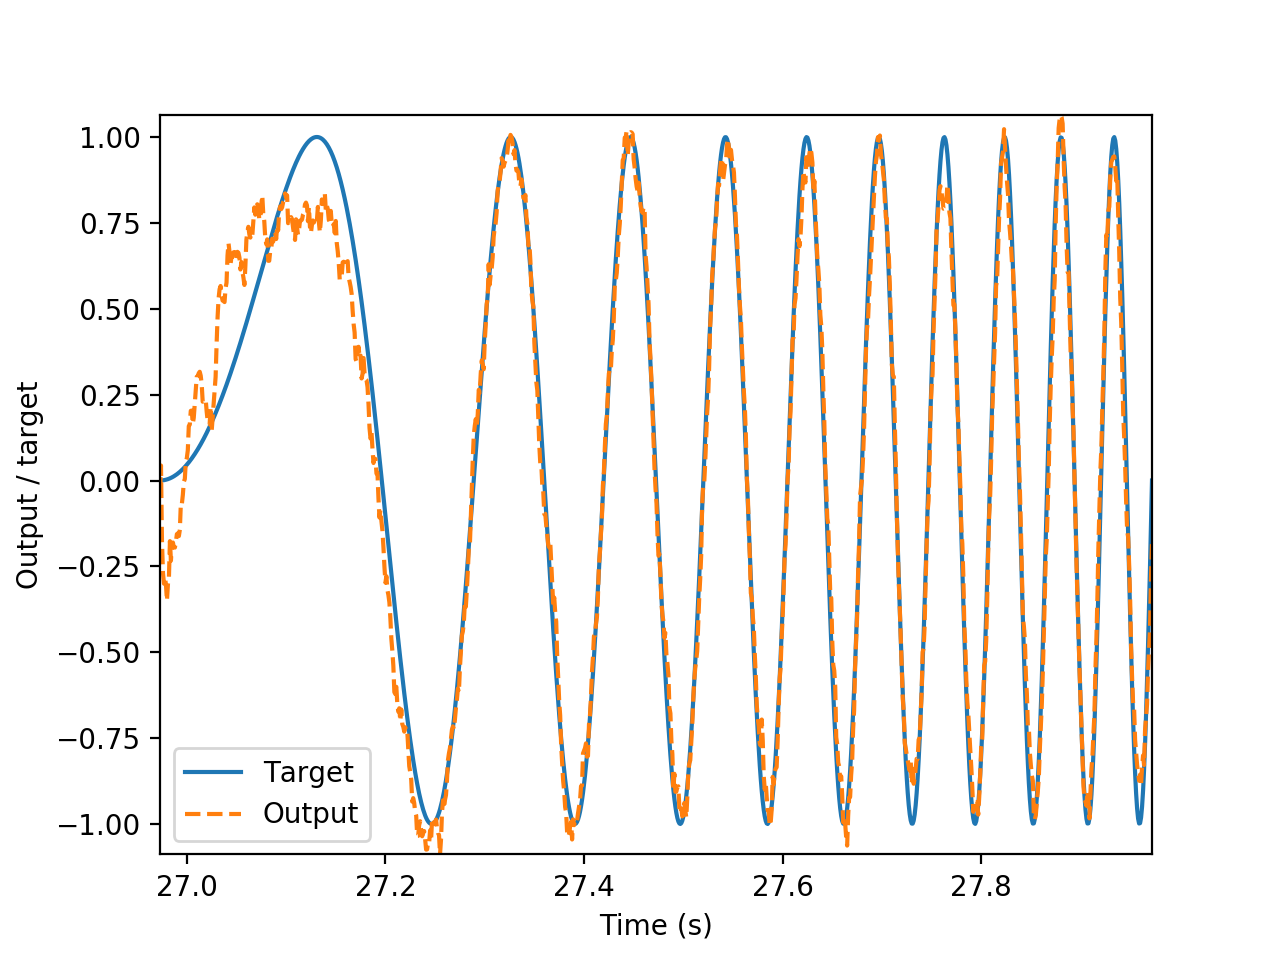

In [61]:
num_batches = 10
trials_per_batch = 100

def two_norm(params):
    return np.sqrt(np.sum([np.sum(e ** 2) for e in params.values()]))

fig = plt.figure()
ax = plt.axes()
line_target = plt.plot(ts_target.times, ts_target.samples)
line_output = plt.plot(ts_output0.times, ts_output0.samples, '--')
plt.legend(['Target', 'Output'])
plt.xlabel('Time (s)')
plt.ylabel('Output / target');
fig.canvas.draw();

with tnrange(num_batches, desc='batches') as tqdm_batches:
    for _ in range(num_batches):
        with tnrange(trials_per_batch, desc='trials', leave=False) as tqdm_trials:
            for _ in range(trials_per_batch):
                # - Get this trial
                pass

                # - One step of Adam training
                loss, grad_loss = lyrRes.train_adam(ts_input, ts_target)

                # - Update statistics
                tqdm_trials.set_postfix(loss=loss(),
                                        #norm_g=two_norm(grad_loss()),
                                        min_tau=int(np.min(lyrRes.tau) / 1e-3),
                                        refresh=False)
                tqdm_trials.update()
            
            # - Update batch progress
            tqdm_batches.update()
            ts_output = lyrRes.evolve(ts_input)
            line_output[0].set_data(ts_output.times, ts_output.samples)
            line_target[0].set_data(ts_output.times, ts_target.samples)
            ax.set_xlim([np.min(ts_output.times), np.max(ts_output.times)])
            ax.set_ylim([np.min(ts_output.samples), np.max(ts_output.samples)])
            fig.canvas.draw()


If all has gone according to plan, the output of the reservoir should closely match the target signal. We can see the effect of training by examining the distribution of network parameters below.

<IPython.core.display.Javascript object>


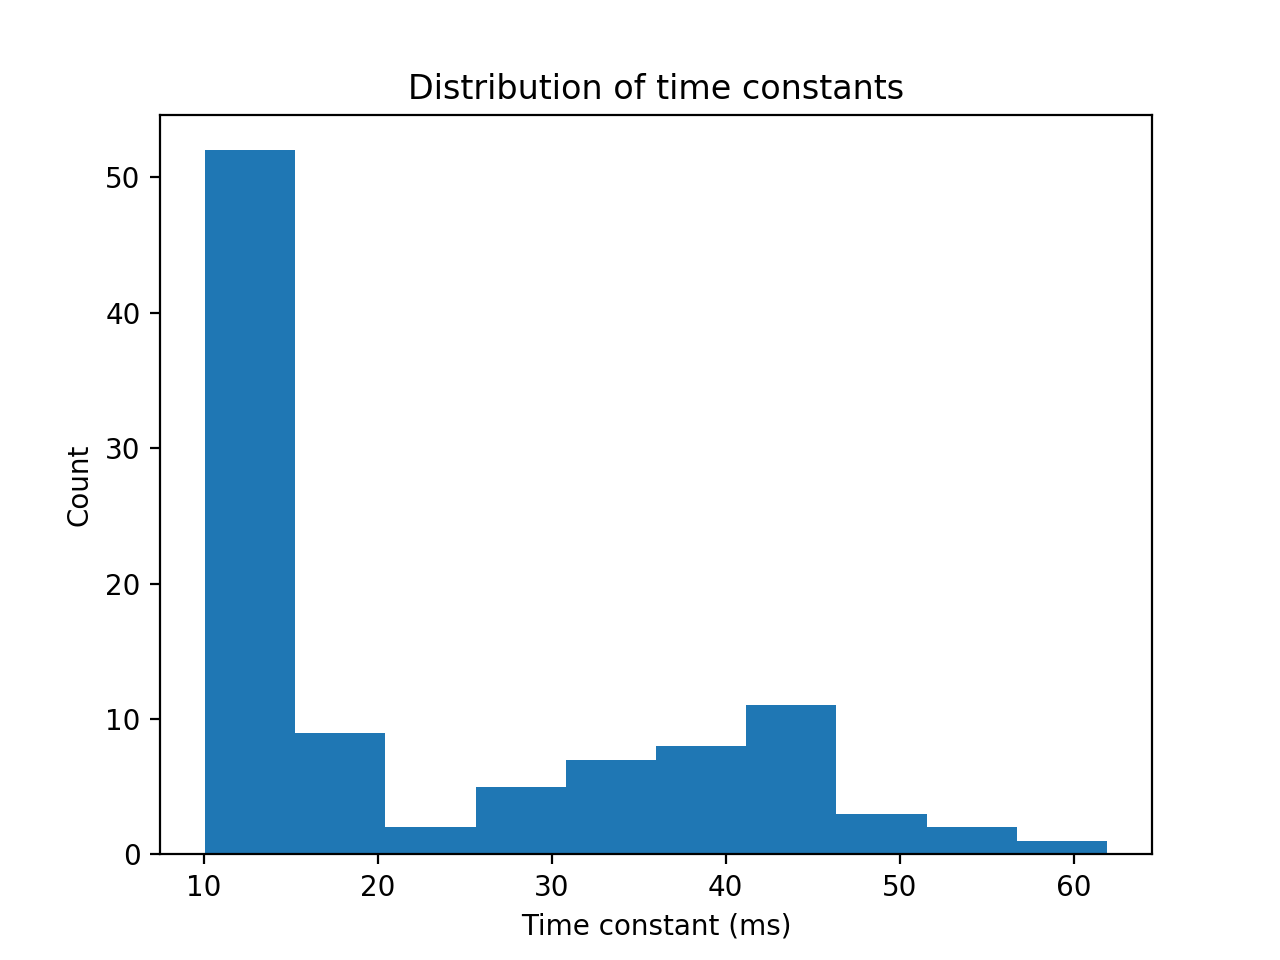

<IPython.core.display.Javascript object>


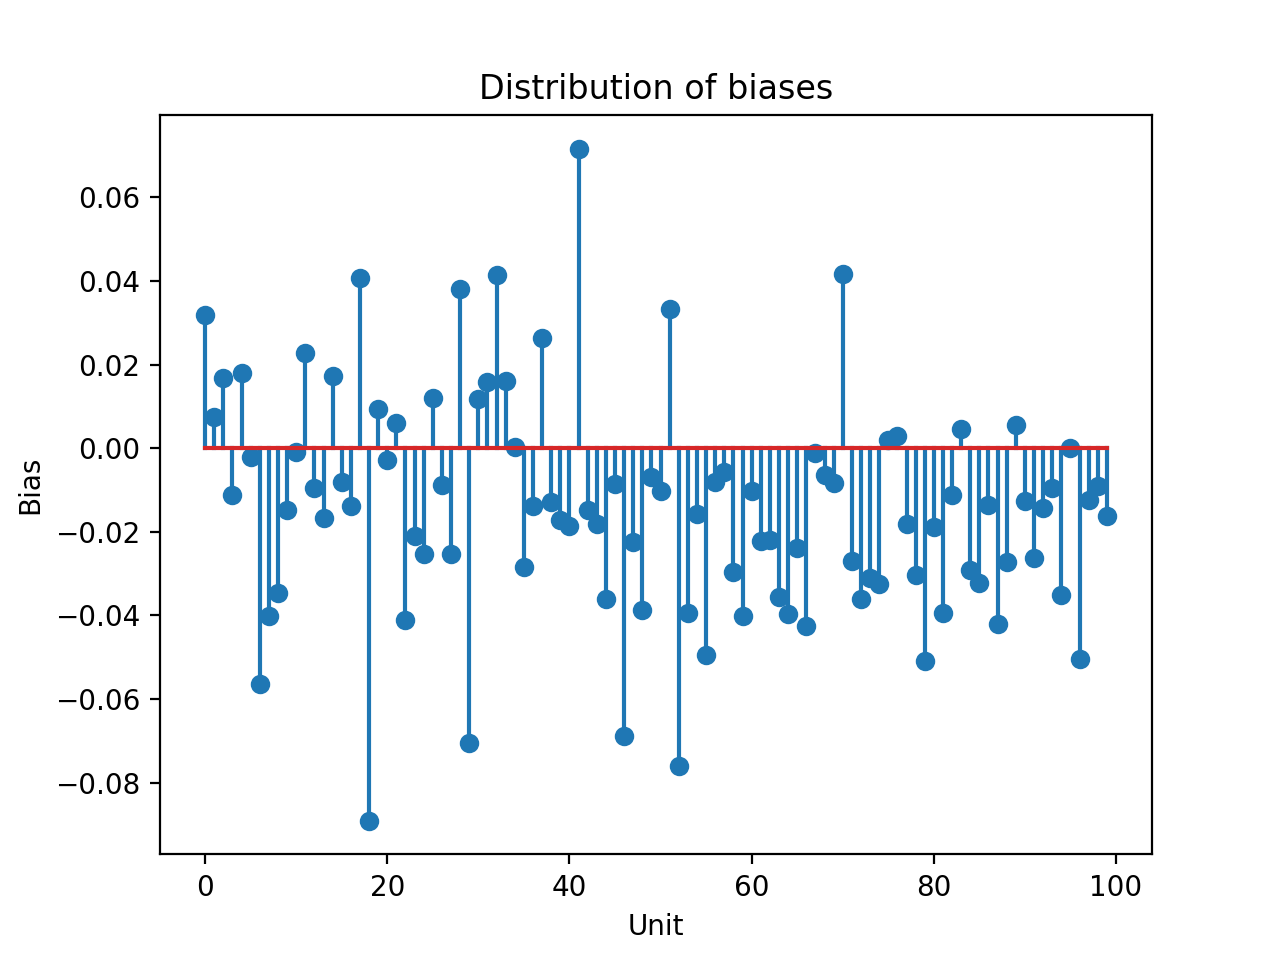

WARNING    /anaconda3/envs/py36_tf/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
 [py.warnings]


<IPython.core.display.Javascript object>


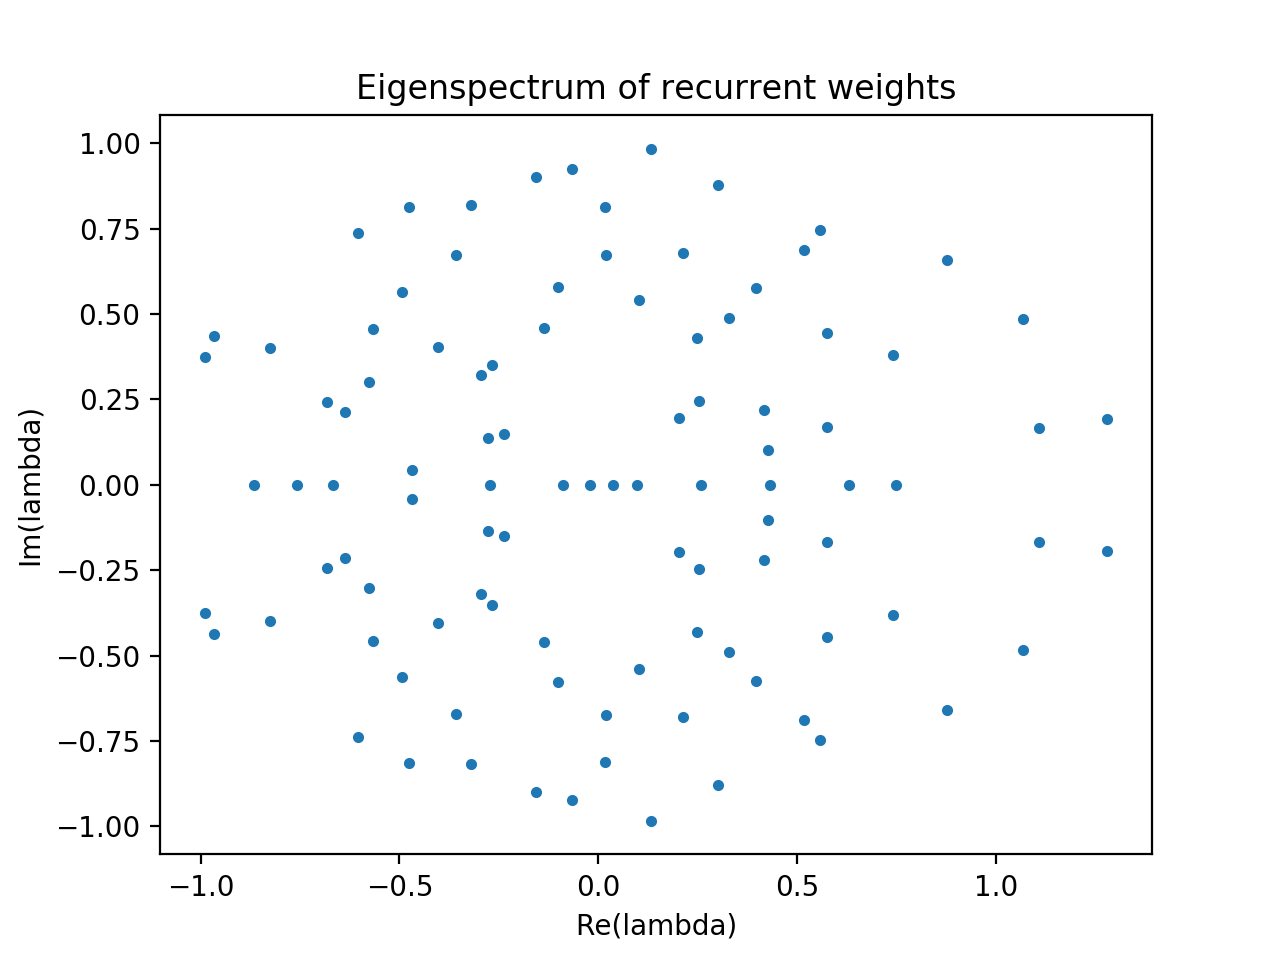

In [44]:
# - Plot the network time constants
plt.figure()
plt.hist(lyrRes.tau / 1e-3);
plt.xlabel('Time constant (ms)');
plt.ylabel('Count');
plt.title('Distribution of time constants');

# - Plot the recurrent layer biases
plt.figure()
plt.stem(lyrRes.bias);
plt.title('Distribution of biases')
plt.xlabel('Unit')
plt.ylabel('Bias');

# - Plot the recurrent layer eigenspectrum
plt.figure()
eigs = np.linalg.eigvals(lyrRes.w_recurrent)
plt.plot(np.real(eigs), np.imag(eigs), '.')
plt.title('Eigenspectrum of recurrent weights')
plt.xlabel('Re(lambda)')
plt.ylabel('Im(lambda)');